### Our task is to execute the process for proactive detection of fraud while answering following questions.
1. Data cleaning including missing values, outliers and multi-collinearity.  
2. Describe your fraud detection model in elaboration.  
3. How did you select variables to be included in the model?  
4. Demonstrate the performance of the model by using best set of tools.  
5. What are the key factors that predict fraudulent customer?  
6. Do these factors make sense? If yes, How? If not, How not?  
7. What kind of prevention should be adopted while company update its infrastructure?
8. Assuming these actions have been implemented, how would you determine if they work?

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
df = pd.read_csv('Fraud.csv')
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [20]:
print("Shape:", df.shape)

Shape: (6362620, 11)


In [21]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB
None


In [22]:
df.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


In [23]:
df.isnull().sum()

,0
step,0
type,0
amount,0
nameOrig,0
oldbalanceOrg,0
newbalanceOrig,0
nameDest,0
oldbalanceDest,0
newbalanceDest,0
isFraud,0


### My observation:
- Dataset has 6362620 rows and 11 columns
- No Missing values are present
- Data type includes numerical and categorical variables
- Target variable 'isFraud' is highly imbalanced

In [24]:
# Froud distribution
df['isFraud'].value_counts()

,count
isFraud,
0,6354407
1,8213


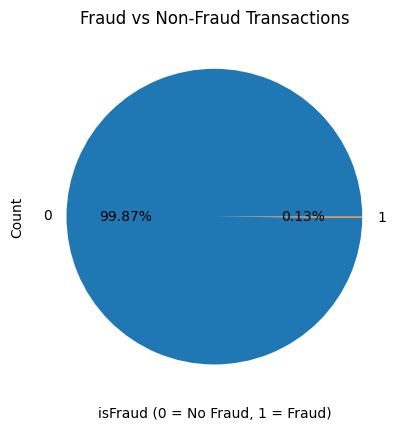

In [25]:
df['isFraud'].value_counts().plot(kind='pie',autopct='%1.2f%%',title='Fraud vs Non-Fraud Transactions')
plt.xlabel('isFraud (0 = No Fraud, 1 = Fraud)')
plt.ylabel('Count')
plt.show()

In [26]:
df['isFraud'].value_counts(normalize=True)

,proportion
isFraud,
0,0.998709
1,0.001291


In [27]:
df['type'].value_counts()

,count
type,
CASH_OUT,2237500
PAYMENT,2151495
CASH_IN,1399284
TRANSFER,532909
DEBIT,41432


In [28]:
fraud_by_type = pd.crosstab(df['type'], df['isFraud'], normalize='index')

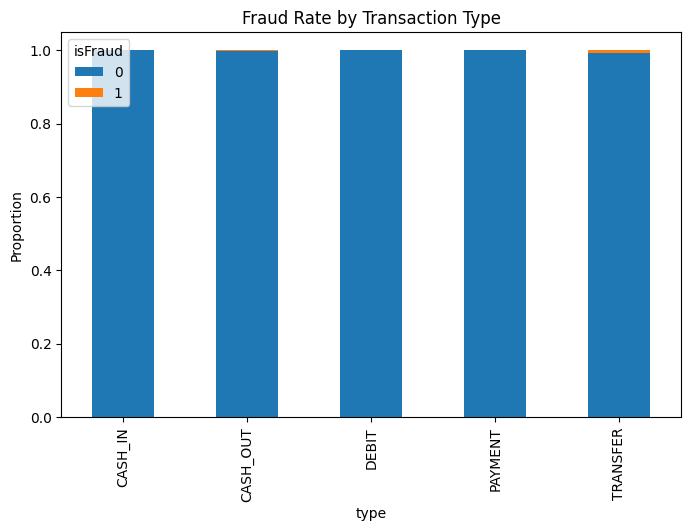

In [29]:
fraud_by_type.plot(kind='bar',stacked=True,figsize=(8,5),title='Fraud Rate by Transaction Type')
plt.ylabel('Proportion')
plt.show()

In [30]:
df.isnull().sum()

,0
step,0
type,0
amount,0
nameOrig,0
oldbalanceOrg,0
newbalanceOrig,0
nameDest,0
oldbalanceDest,0
newbalanceDest,0
isFraud,0


In [31]:
df['isMerchant'] = df['nameDest'].str.startswith('M').astype(int)

In [32]:
df['isMerchant'].head()

,isMerchant
0,1
1,1
2,0
3,0
4,1


In [33]:
# Balance Change Features
df['org_balance_change'] = df['oldbalanceOrg'] - df['newbalanceOrig']
df['dest_balance_change'] = df['newbalanceOrig'] - df['oldbalanceOrg']

In [34]:
df['org_balance_change'].head()

,org_balance_change
0,9839.64
1,1864.28
2,181.00
3,181.00
4,11668.14


In [35]:
df['dest_balance_change'].head()

,dest_balance_change
0,-9839.64
1,-1864.28
2,-181.00
3,-181.00
4,-11668.14


In [36]:
# Log Transformation of Amount
df['log_amount'] = np.log1p(df['amount'])   # Amount is heavily skewedand and Log reduces outlier impact

In [37]:
df['log_amount'].value_counts()

,count
log_amount,
16.118096,3207
9.210440,88
8.517393,79
9.615872,68
6.216606,65
...,...
11.930652,1
12.740382,1
12.974814,1


In [38]:
# Drop Identifier Columns
df.drop(['nameOrig','nameDest'], axis=1, inplace=True)  # “IDs don’t generalize and can cause overfitting.”

In [39]:
df.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,isMerchant,org_balance_change,dest_balance_change,log_amount
0,1,PAYMENT,9839.64,170136.0,160296.36,0.0,0.0,0,0,1,9839.64,-9839.64,9.194276
1,1,PAYMENT,1864.28,21249.0,19384.72,0.0,0.0,0,0,1,1864.28,-1864.28,7.531166
2,1,TRANSFER,181.00,181.0,0.00,0.0,0.0,1,0,0,181.00,-181.00,5.204007
3,1,CASH_OUT,181.00,181.0,0.00,21182.0,0.0,1,0,0,181.00,-181.00,5.204007
4,1,PAYMENT,11668.14,41554.0,29885.86,0.0,0.0,0,0,1,11668.14,-11668.14,9.364703


In [40]:
# Encode Categorical Variable USE LABEL ENCODING
from sklearn.preprocessing import LabelEncoder

In [41]:
le = LabelEncoder()
df['type_encoded'] = le.fit_transform(df['type'])

In [42]:
df[['type', 'type_encoded']].head()

,type,type_encoded
0,PAYMENT,3
1,PAYMENT,3
2,TRANSFER,4
3,CASH_OUT,1
4,PAYMENT,3


from matplotlib import pyplot as plt
_df_0['type_encoded'].plot(kind='hist', bins=20, title='type_encoded')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_1.groupby('type').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['type_encoded'].plot(kind='line', figsize=(8, 4), title='type_encoded')
plt.gca().spines[['top', 'right']].set_visible(False)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_3['type'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_3, x='type_encoded', y='type', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

In [43]:
df

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,isMerchant,org_balance_change,dest_balance_change,log_amount,type_encoded
0,1,PAYMENT,9839.64,170136.00,160296.36,0.00,0.00,0,0,1,9839.64,-9839.64,9.194276,3
1,1,PAYMENT,1864.28,21249.00,19384.72,0.00,0.00,0,0,1,1864.28,-1864.28,7.531166,3
2,1,TRANSFER,181.00,181.00,0.00,0.00,0.00,1,0,0,181.00,-181.00,5.204007,4
3,1,CASH_OUT,181.00,181.00,0.00,21182.00,0.00,1,0,0,181.00,-181.00,5.204007,1
4,1,PAYMENT,11668.14,41554.00,29885.86,0.00,0.00,0,0,1,11668.14,-11668.14,9.364703,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,339682.13,339682.13,0.00,0.00,339682.13,1,0,0,339682.13,-339682.13,12.735768,1
6362616,743,TRANSFER,6311409.28,6311409.28,0.00,0.00,0.00,1,0,0,6311409.28,-6311409.28,15.657870,4
6362617,743,CASH_OUT,6311409.28,6311409.28,0.00,68488.84,6379898.11,1,0,0,6311409.28,-6311409.28,15.657870,1
6362618,743,TRANSFER,850002.52,850002.52,0.00,0.00,0.00,1,0,0,850002.52,-850002.52,13.652996,4


In [44]:
# Drop orignal type
df.drop('type', axis=1, inplace=True)   # avoid redundancy

In [45]:
# Encoding Mapping
type_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
type_mapping

{'CASH_IN': np.int64(0),
 'CASH_OUT': np.int64(1),
 'DEBIT': np.int64(2),
 'PAYMENT': np.int64(3),
 'TRANSFER': np.int64(4)}

In [ ]:
df

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,isMerchant,org_balance_change,dest_balance_change,log_amount,type_encoded
0,1,9839.64,170136.00,160296.36,0.00,0.00,0,0,1,9839.64,-9839.64,9.194276,3
1,1,1864.28,21249.00,19384.72,0.00,0.00,0,0,1,1864.28,-1864.28,7.531166,3
2,1,181.00,181.00,0.00,0.00,0.00,1,0,0,181.00,-181.00,5.204007,4
3,1,181.00,181.00,0.00,21182.00,0.00,1,0,0,181.00,-181.00,5.204007,1
4,1,11668.14,41554.00,29885.86,0.00,0.00,0,0,1,11668.14,-11668.14,9.364703,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,339682.13,339682.13,0.00,0.00,339682.13,1,0,0,339682.13,-339682.13,12.735768,1
6362616,743,6311409.28,6311409.28,0.00,0.00,0.00,1,0,0,6311409.28,-6311409.28,15.657870,4
6362617,743,6311409.28,6311409.28,0.00,68488.84,6379898.11,1,0,0,6311409.28,-6311409.28,15.657870,1
6362618,743,850002.52,850002.52,0.00,0.00,0.00,1,0,0,850002.52,-850002.52,13.652996,4


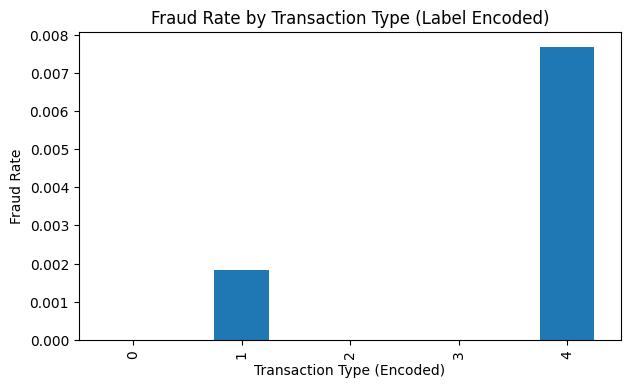

In [46]:
fraud_by_type = df.groupby('type_encoded')['isFraud'].mean()

plt.figure(figsize=(7,4))
fraud_by_type.plot(kind='bar', title='Fraud Rate by Transaction Type (Label Encoded)')
plt.xlabel('Transaction Type (Encoded)')
plt.ylabel('Fraud Rate')
plt.show()

In [47]:
train = df[df['step'] <= 500]
test  = df[df['step'] > 500]

X_train = train.drop('isFraud', axis=1)
y_train = train['isFraud']

X_test = test.drop('isFraud', axis=1)
y_test = test['isFraud']

In [54]:
X_train.head()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFlaggedFraud,isMerchant,org_balance_change,dest_balance_change,log_amount,type_encoded
0,1,9839.64,170136.0,160296.36,0.0,0.0,0,1,9839.64,-9839.64,9.194276,3
1,1,1864.28,21249.0,19384.72,0.0,0.0,0,1,1864.28,-1864.28,7.531166,3
2,1,181.00,181.0,0.00,0.0,0.0,0,0,181.00,-181.00,5.204007,4
3,1,181.00,181.0,0.00,21182.0,0.0,0,0,181.00,-181.00,5.204007,1
4,1,11668.14,41554.0,29885.86,0.0,0.0,0,1,11668.14,-11668.14,9.364703,3


In [55]:
y_train.head()

,isFraud
0,0
1,0
2,1
3,1
4,0


In [48]:
from xgboost import XGBClassifier

In [49]:
xgb = XGBClassifier(
    scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum(),
    eval_metric='auc',
    random_state=42
)

In [50]:
xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

In [56]:
xgb_pred = xgb.predict(X_test)
xgb_prob = xgb.predict_proba(X_test)[:, 1]

In [60]:
from sklearn.metrics import classification_report
print(classification_report(y_test, xgb_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    298161
           1       0.93      0.89      0.91      2652

    accuracy                           1.00    300813
   macro avg       0.97      0.94      0.95    300813
weighted avg       1.00      1.00      1.00    300813



In [63]:
from sklearn.metrics import roc_auc_score

In [64]:
roc_auc_score(y_test, xgb_prob)

np.float64(0.9998347322581644)

In [65]:
# Precision–Recall Curve
from sklearn.metrics import precision_recall_curve

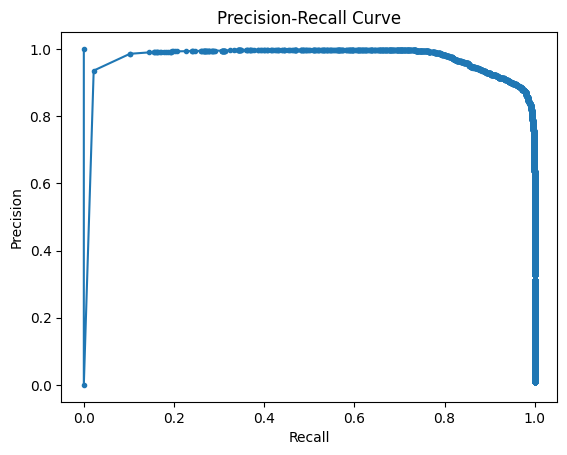

In [66]:
precission, recall, _ = precision_recall_curve(y_test, xgb_prob)

plt.plot(recall, precission, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

In [68]:
importance = pd.Series(xgb.feature_importances_,index=X_train.columns).sort_values(ascending=False)
importance.head(10)

,0
dest_balance_change,0.682859
newbalanceOrig,0.076084
log_amount,0.049141
type_encoded,0.045548
isMerchant,0.040598
amount,0.035038
newbalanceDest,0.022324
oldbalanceOrg,0.021234
oldbalanceDest,0.011036
org_balance_change,0.008548
